In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import kagglehub
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import pathlib
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
import cv2

kaggle_wound_path = kagglehub.dataset_download('yasinpratomo/wound-dataset')
dataset_path = f"{kaggle_wound_path}/Wound_dataset"
print(dataset_path)

for d in dataset_path:
  print(d)

for root, dirs, files in os.walk(dataset_path):
  # print("Directory: ", root)
  for filename in files:
    full_filepath = os.path.join(root, filename)
    # print(f" = {full_filepath}")

2025-07-18 14:48:06.069562: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752850086.092657    8077 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752850086.102324    8077 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input//Wound_dataset
/
k
a
g
g
l
e
/
i
n
p
u
t
/
/
W
o
u
n
d
_
d
a
t
a
s
e
t


In [2]:
import os
import shutil
import random
from pathlib import Path

# CONFIGURATION
original_dataset_dir = dataset_path
output_base_dir = "dataset_split"
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15
SEED = 123

random.seed(SEED)

# Make output folders
for split in ["train", "val", "test"]:
    split_path = Path(output_base_dir) / split
    split_path.mkdir(parents=True, exist_ok=True)

# Go through each class
for class_name in os.listdir(original_dataset_dir):
    class_dir = os.path.join(original_dataset_dir, class_name)
    if not os.path.isdir(class_dir):
        continue  # skip non-folder items

    images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
    random.shuffle(images)

    total = len(images)
    train_cutoff = int(train_ratio * total)
    val_cutoff = train_cutoff + int(val_ratio * total)

    train_images = images[:train_cutoff]
    val_images = images[train_cutoff:val_cutoff]
    test_images = images[val_cutoff:]

    def move_images(image_list, split):
        split_class_dir = Path(output_base_dir) / split / class_name
        split_class_dir.mkdir(parents=True, exist_ok=True)
        for img_name in image_list:
            src = os.path.join(class_dir, img_name)
            dst = os.path.join(split_class_dir, img_name)
            shutil.copy2(src, dst)

    move_images(train_images, "train")
    move_images(val_images, "val")
    move_images(test_images, "test")

    print(f"Class '{class_name}': {len(train_images)} train, {len(val_images)} val, {len(test_images)} test")

print("Dataset split complete.")


Class 'Abrasions': 59 train, 12 val, 14 test
Class 'Stab_wound': 16 train, 3 val, 4 test
Class 'Cut': 35 train, 7 val, 8 test
Class 'Burns': 41 train, 8 val, 10 test
Class 'Ingrown_nails': 21 train, 4 val, 6 test
Class 'Laceration': 42 train, 9 val, 10 test
Class 'Bruises': 85 train, 18 val, 19 test
Dataset split complete.


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


## image mode = RGB -> 3 channels

In [4]:
def preprocess(img):
  if img.shape[2] == 3:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (224, 224))
  img = img.astype("float32")

  img = preprocess_input(img)
  img = np.expand_dims(img, axis=0)
  return img

In [5]:
BATCH_SIZE = 32
IMG_WIDTH = 180
IMG_HEIGHT = 180

In [6]:
train_set = keras.utils.image_dataset_from_directory(
    "dataset_split/train",
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

Found 299 files belonging to 7 classes.


I0000 00:00:1752850090.803642    8077 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752850090.804284    8077 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [7]:
validation_set = keras.utils.image_dataset_from_directory(
    "dataset_split/val",
    image_size=(IMG_HEIGHT, IMG_HEIGHT),
    batch_size=BATCH_SIZE
)

Found 61 files belonging to 7 classes.


In [8]:
test_set = keras.utils.image_dataset_from_directory(
    "dataset_split/test",
    image_size=(IMG_HEIGHT, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 71 files belonging to 7 classes.


## Data augmentation as there was alot of overfitting (train doing well, val doing not well)

In [9]:
# data_augmentation = keras.Sequential([
#     layers.RandomFlip("horizontal_and_vertical"),
#     layers.RandomRotation(0.2),
#     layers.RandomZoom(0.1),
#     layers.RandomContrast(0.2),
# ])

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomTranslation(0.1, 0.1),
])


In [10]:
class_names = train_set.class_names
print(class_names)

['Abrasions', 'Bruises', 'Burns', 'Cut', 'Ingrown_nails', 'Laceration', 'Stab_wound']


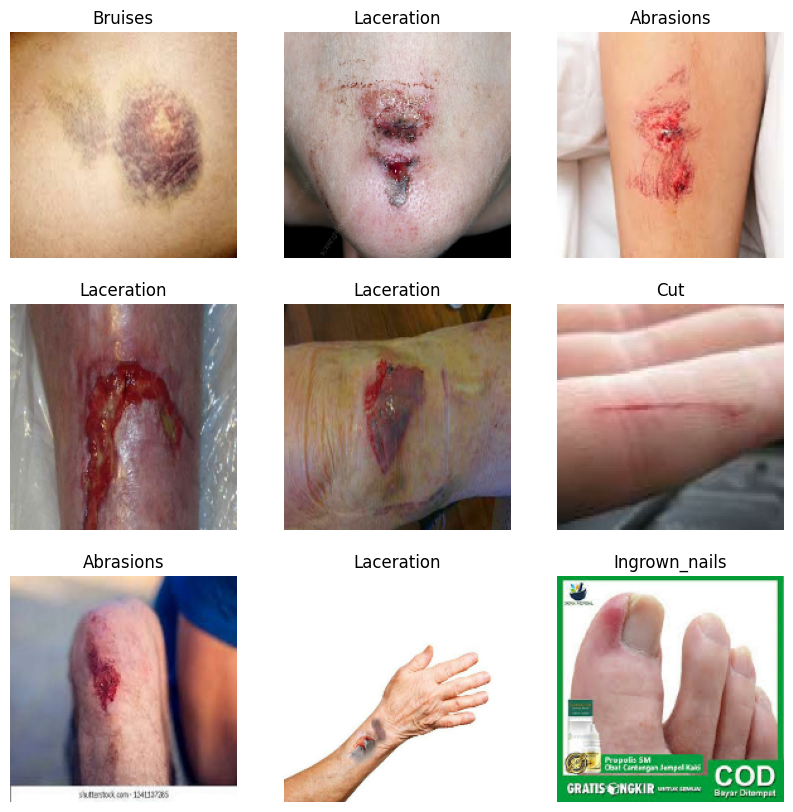

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
for image_batch, labels_batch in train_set:
  print(f"IMAGE BATCH SHAPE: {image_batch} <-> LABELS BATCH SHAPE: {labels_batch}")

IMAGE BATCH SHAPE: [[[[166.94444    130.94444     96.94444   ]
   [141.         105.          71.        ]
   [118.94444     82.94444     48.944443  ]
   ...
   [ 34.          23.           5.        ]
   [ 33.          22.           4.        ]
   [ 33.          22.           4.        ]]

  [[161.82408    125.82407     91.82407   ]
   [134.52779     98.52777     64.52777   ]
   [117.5463      81.5463      47.546295  ]
   ...
   [ 36.          23.           6.        ]
   [ 35.          22.           5.        ]
   [ 35.          22.           5.        ]]

  [[156.         120.          86.        ]
   [130.03703     94.03703     60.037033  ]
   [118.182106    82.182106    48.182102  ]
   ...
   [ 38.54011     22.540112     6.540111  ]
   [ 36.77778     20.777779     4.7777786 ]
   [ 36.77778     20.777779     4.7777786 ]]

  ...

  [[163.61128    120.61128     88.61128   ]
   [173.00949    130.00949     98.00949   ]
   [188.66693    145.66693    113.66694   ]
   ...
   [  8.586134  

In [13]:
AUTOTUNE = tf.data.AUTOTUNE
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_set = validation_set.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
%pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [15]:
import optuna

tf.keras.backend.clear_session()

def lr_scheduler(num_epochs, learning_rate):
  if num_epochs < 30:
    return learning_rate
  else:
    return float(learning_rate * tf.math.exp(-0.1))

def objective(trial):
  optim_learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2)
  optim_dropout_rate = trial.suggest_float("dropout", 0.2, 0.5)
  optim_weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-2)
  optim_patience = trial.suggest_int("patience", 5, 10)

  num_classes = len(class_names)


  base_model = EfficientNetV2B0(include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), weights='imagenet')
  base_model.trainable = True
  for layer in base_model.layers[:-20]:
    layer.trainable = False

  inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
  x = data_augmentation(inputs)
  x = preprocess_input(x)
  x = base_model(x, training=False)
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dropout(optim_dropout_rate)(x)
  outputs = layers.Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(optim_weight_decay))(x)

  vision_network = keras.Model(inputs, outputs)



  tf.keras.backend.clear_session()
  vision_network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=optim_learning_rate),
                        loss=keras.losses.SparseCategoricalCrossentropy(),
                        metrics=["accuracy"])

  print(vision_network.summary())

  EPOCHS = 50

  learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
  # early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=optim_patience, restore_best_weights=True)
  early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # setting unique model checkpoint path for each trial (because if overwriting same path, gives error and best hyperparameters won't save)
  checkpoint_path = f"best_model_trial_{trial.number}.keras"
  checkpoint = keras.callbacks.ModelCheckpoint(
      checkpoint_path, save_best_only=True, monitor="val_loss", mode="min"
  )

  history = vision_network.fit(
      train_set,
      validation_data=validation_set,
      epochs=EPOCHS,
      callbacks=[learning_rate_scheduler, early_stop, checkpoint],
  )

  return min(history.history["val_loss"])

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

IndentationError: unexpected indent (3566806710.py, line 48)

In [ ]:
best_trial_number = study.best_trial.number
best_model_path = f"best_model_trial_{best_trial_number}.keras"

best_model = tf.keras.models.load_model(best_model_path)

converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open("model.tflite", "wb") as f:
    f.write(tflite_model)

print(f"TFLite model saved as model.tflite (from trial #{best_trial_number})")


## reusing best params to compile model and retraining ->  then plotting accuracy

In [ ]:
best_parameters = study.best_trial.params

# rebuild the model using the best parameters found
base_model = EfficientNetV2B0(include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), weights='imagenet')
base_model.trainable = False

inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(best_parameters["dropout"])(x)
outputs = layers.Dense(
    len(class_names), 
    activation='softmax', 
    kernel_regularizer=regularizers.l2(best_parameters["weight_decay"])
)(x)

vision_network = keras.Model(inputs, outputs)

tf.keras.backend.clear_session()
vision_network.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_parameters["learning_rate"]),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=best_parameters["patience"], restore_best_weights=True)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

history = vision_network.fit(
    train_set,
    validation_data=validation_set,
    epochs=100,
    callbacks=[lr_schedule, early_stop],
    verbose=1
)

accuracy = history.history["accuracy"]
validation_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
validation_loss = history.history["val_loss"]
epochs_range = range(len(accuracy))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label="Training Accuracy")
plt.plot(epochs_range, validation_accuracy, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, validation_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()


vision_network.save("final_model.keras")

# converting to TFLite for loading into mobile app
converter = tf.lite.TFLiteConverter.from_keras_model(vision_network)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open("final_model.tflite", "wb") as f:
    f.write(tflite_model)

print("TFLite model saved as final_model.tflite")


# Evaluating on test set

In [ ]:
test_loss, test_accuracy = vision_network.evaluate(test_set)
print(f"Test accuracy: {test_accuracy:.4f}")